<a href="https://colab.research.google.com/github/KimaniKibuthu/Delay-Prediction/blob/main/Experimental_Flight_delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Delay Prediction
The aim of this project is to predict whether a flight would be delayed or not.

# Introduction
The flow of the project will include:
* Data retrieval
* Exploratory Data Analysis
* Modelling

# Install  & Import Libraries

## Install Libraries


In [20]:
# Uninstall existing CUDA 
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [21]:
# Install the latest CUDA
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-02-22 08:21:09--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.16.29
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.16.29|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-02-22 08:21:10--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?MJtWnjwbTKp2KyVx7EQ_lhwVOWVW5hmNxKsBEn1DSZuLB70FnZ4RNSK_8vJxxYroYool2HoXojrdK8R3OcC7j7-efq20XZwnJWnQh65HGNkmB3b

In [22]:
# Install the plugin
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-2iigosex
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-2iigosex
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4308 sha256=b7d287d4e8d0288340dd2e5a42fdda0cc700bdd7bb43130c76f1a84d763fcd9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wuotvlvr/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [23]:
# Load the plug in
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [24]:
# Install kaggle
! pip install kaggle

In [25]:
# install catboost
! pip install catboost


## Import Libraries

In [26]:
# import the necessary libraries

# Support libraries
import os
import shutil
from zipfile import ZipFile

# EDA libraries
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from catboost import CatBoostClassifier

# Data Retrieval

In [27]:
# Set up the environment to load data from
os.environ["KAGGLE_USERNAME"] = 'kimanikibuthu'
os.environ["KAGGLE_KEY"] = 'f85c0bb5d43058fddcce7902e1325677'

In [28]:
# Download the data from the kaggle competition

data_dir = "data/"

!kaggle competitions download -c flight-delays-fall-2018 -p {data_dir}

flight_delays_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
flight_delays_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Unzip the train data first
zip_train = ZipFile('/content/data/flight_delays_train.csv.zip', 'r')
zip_train.extractall('/content/input/')

# Unzip the test data 
zip_test = ZipFile('/content/data/flight_delays_test.csv.zip', 'r')
zip_test.extractall('/content/input/')

# Unzip the sample submission
zip_sample_submission = ZipFile('/content/data/sample_submission.csv.zip', 'r')
zip_sample_submission.extractall('/content/input/')

In [30]:
# Save in a variable for exploration
flight_delay_df = pd.read_csv('/content/input/flight_delays_train.csv')

In [31]:
# Save test data in a variable
test = pd.read_csv('/content/input/flight_delays_test.csv')

In [32]:
# Sample csv
sample = pd.read_csv('/content/input/sample_submission.csv')

# Exploratory Data Analysis
The goal here is to clean the data, explore it and transform it for modelling purposes.

## Explore the data


In [33]:
# Look at a sample of the data
flight_delay_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [34]:
# Look at the info
flight_delay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


The data has 100,000 entries with zero null values. Let's now look at the distribution of the data.

### Target Column (dep_delayed_15min)

In [35]:
# Let's rename the column to state of delay
flight_delay_df.rename(columns={'dep_delayed_15min': 'state_of_delay'}, 
                       inplace=True)

In [36]:
# See the unique values
flight_delay_df.state_of_delay.value_counts()

N    80956
Y    19044
Name: state_of_delay, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


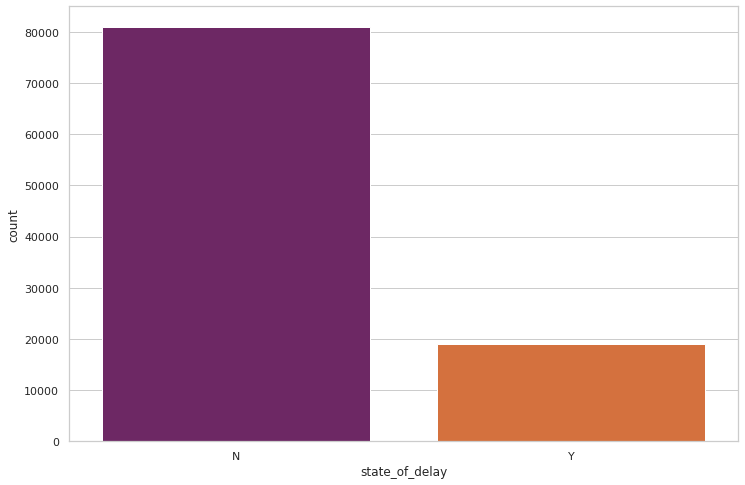

In [37]:
# Visualize the value counts
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('state_of_delay', data=flight_delay_df, palette='inferno')

There is some imbalance in our class labels, hence we will have to deal with that.

In [38]:
# Convert to numerical
mapping = {'N': 0,
           'Y': 1}

flight_delay_df['state_of_delay'] = flight_delay_df['state_of_delay'].map(mapping)

### Month

In [39]:
# Let's generate a cleaner 
def date_cleaner(date_column, dataset):
  ''' Cleans the date columns, converting the values to integers. 
       Eg 'c-8' to 8 '''
  # Get column values
  for column in date_column:
    column_values = dataset[column].values

    # Clean the values
    for index, value in enumerate(column_values):
      column_values[index] = int(value.split('-')[1])

    # Convert the new values to a dataframe and append to the new dataframe
    dataset[column] = pd.Series(column_values)

  
  return dataset



In [40]:
# Convert all the columns to integer values
flight_delay_clean = date_cleaner(['Month', 'DayofMonth', 'DayOfWeek'],
                                  flight_delay_df)

In [41]:
# Check the distribution
flight_delay_clean.Month.describe()

count     100000
unique        12
top            8
freq        8830
Name: Month, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


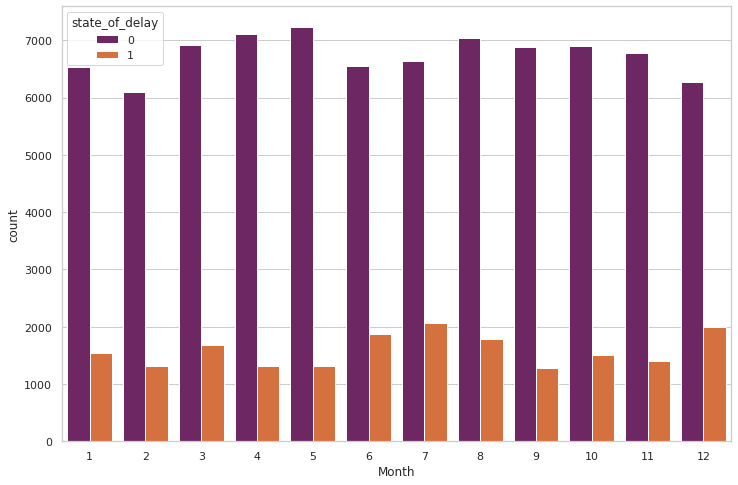

In [42]:
# Visualize the relationship between Month and delay
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Month',
              hue='state_of_delay', 
              data=flight_delay_clean,
              palette='inferno')

There is seasonality on the increase of air travel. There is a significant rise of delays in June, July and December despite the flight count being lower.

### Unique Carrier

In [43]:
# Check the distribution
flight_delay_clean.UniqueCarrier.describe()

count     100000
unique        22
top           WN
freq       15082
Name: UniqueCarrier, dtype: object

In [44]:
flight_delay_clean.UniqueCarrier.unique()

array(['AA', 'US', 'XE', 'OO', 'WN', 'NW', 'DL', 'OH', 'AS', 'UA', 'MQ',
       'CO', 'EV', 'DH', 'YV', 'F9', 'AQ', 'TZ', 'HP', 'B6', 'FL', 'HA'],
      dtype=object)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


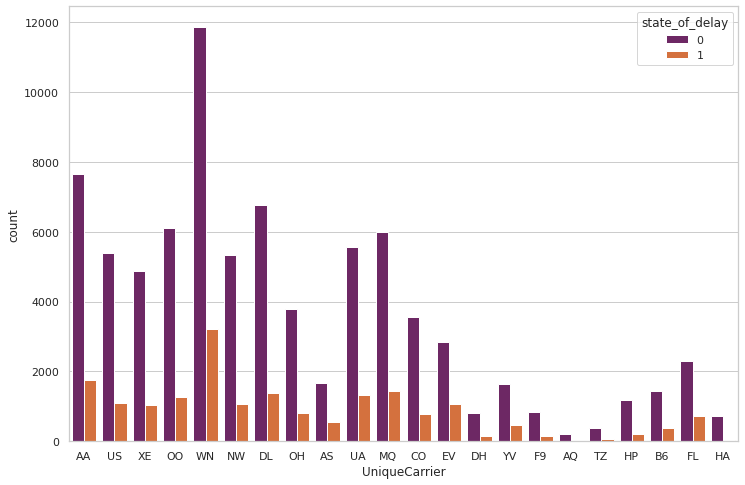

In [45]:
# See how it affects delay
# Visualize the relationship between Unique Carrier and delay
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('UniqueCarrier',
              hue='state_of_delay', 
              data=flight_delay_clean,
              palette='inferno')

The more flights a carrier has, the more it is likely to endure delays

### Origin Airport

In [46]:
# Check the distribution
flight_delay_clean.Origin.describe()

count     100000
unique       289
top          ATL
freq        5834
Name: Origin, dtype: object

In [47]:
# Check value Counts
flight_delay_clean.Origin.value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
       ... 
VIS       1
VCT       1
ADK       1
WYS       1
ILG       1
Name: Origin, Length: 289, dtype: int64

### Departure Airport


In [48]:
# Check the distribution
flight_delay_clean.Dest.describe()

count     100000
unique       289
top          ATL
freq        5795
Name: Dest, dtype: object

In [49]:
# Check value Counts
flight_delay_clean.Dest.value_counts()

ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
       ... 
LWB       1
TTN       1
VCT       1
ACK       1
TEX       1
Name: Dest, Length: 289, dtype: int64

### Departure Time

In [50]:
# Clean the time
def hour_extractor(time_column, data, drop_time=True):
  ''' Extracts the hour from the time column'''
  # Extract the values as a string
  time = data[time_column].values.astype(str)

  # Convert to the format (00:00)
  for index, value in enumerate(time):
      if len(value) == 1:
        time[index] = f'000{value}'
      if len(value) == 2:
        time[index] = f'00{value}'
      if len(value) == 3:
        time[index] = f'0{value}'
  
  for index, value in enumerate(time):
    time[index] = f'{value[0]}{value[1]}:{value[2]}{value[3]}'
  
  # Split the new time to obtain the hour
  hour = []
  for value in time:
      x = int(value.split(':')[0])
      hour.append(x)
  # Convert 24 and 25 to 0 and 1     
  for index, value in enumerate(hour):
    if value == 24:
      hour[index] = 0
    elif value == 25:
      hour[index] = 1
      
  # Convert Hour to dataFrame and append to the data
  Hour = pd.DataFrame(np.array(hour), columns=['Hour'])

  # Append to the dataset
  new_dataset = pd.concat([data, Hour], axis=1)

  if drop_time:
    new_dataset = new_dataset.drop(time_column, axis=1)
  

  return new_dataset





In [51]:
# Create minute column
flight_delay_clean['minute'] = flight_delay_clean['DepTime'] % 100

In [52]:
# Create an hours column
flights_delays_cleaner = hour_extractor('DepTime', 
                                        data=flight_delay_clean, 
                                        drop_time=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


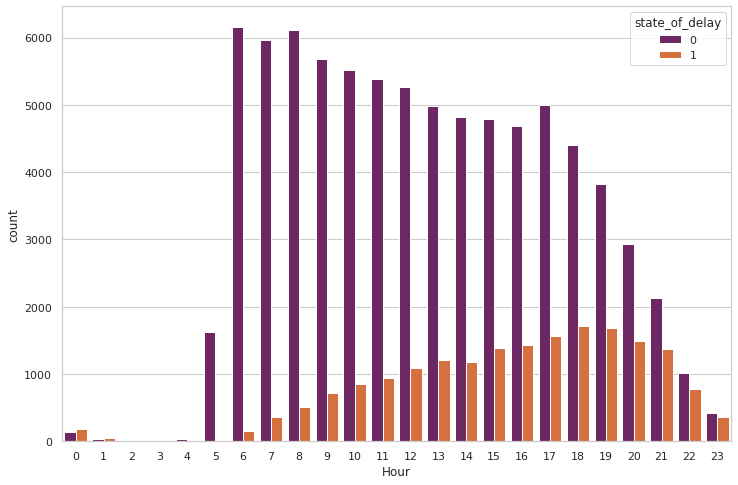

In [53]:
# View the effect on delay

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Hour',
              hue='state_of_delay', 
              data=flights_delays_cleaner,
              palette='inferno')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


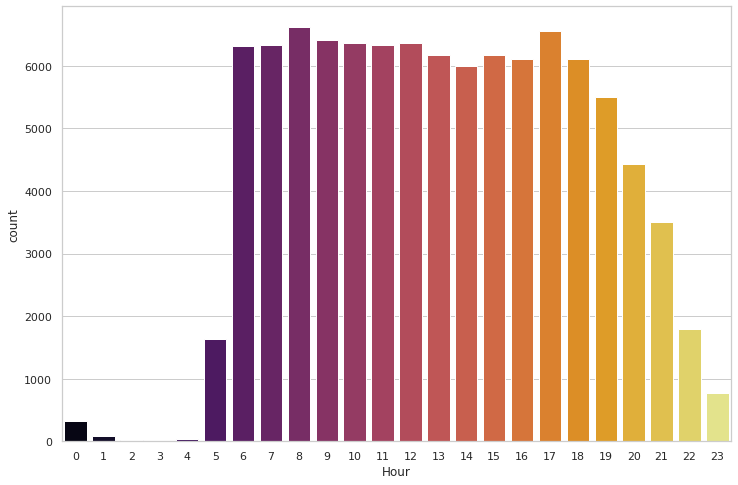

In [54]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Hour', 
              data=flights_delays_cleaner,
              palette='inferno')

There are more delays in the afternoon and in the night despite the flights being the same count.

In [55]:
# create hour squared and powerd to 4 to give hour more emphasis

flights_delays_cleaner['hour_squared'] = flights_delays_cleaner['Hour'] ** 2


### Range 

In [56]:
# Bin the distance
flights_delays_cleaner.loc[flights_delays_cleaner.Distance <= 500 , 'Dist_bin'] = 'vshort'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 500) & (flights_delays_cleaner.Distance <= 1000), 'Dist_bin'] = 'short'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 1000) & (flights_delays_cleaner.Distance <= 1500), 'Dist_bin'] = 'mid'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 1500) & (flights_delays_cleaner.Distance <= 2000), 'Dist_bin'] = 'midlong'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 2000) & (flights_delays_cleaner.Distance <= 2500), 'Dist_bin'] = 'long'
flights_delays_cleaner.loc[flights_delays_cleaner.Distance > 2500, 'Dist_bin'] = 'vlong'


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


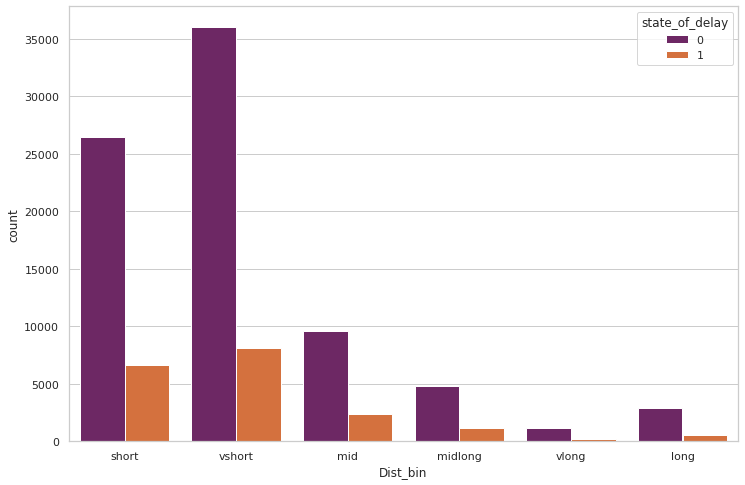

In [57]:
# View how holidays affect delays
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Dist_bin',
              hue='state_of_delay', 
              data=flights_delays_cleaner,
              palette='inferno')

## Transform the data for modelling

### Encode Month, Day of Month, Day of Week and Holiday

In [58]:
# Convert the datatype the time columns
time_columns = ['Month', 'DayofMonth', 'DayOfWeek']

for column in time_columns:
  flights_delays_cleaner[column]=flights_delays_cleaner[column].astype(dtype=np.int64)

### Create New Columns

In [59]:
# Create new column binning hour flights_delays_cleaner
flights_delays_cleaner
flights_delays_cleaner.loc[flights_delays_cleaner.Hour < 6 , 'DepTime_bin'] = 'vem'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour >= 6) & (flights_delays_cleaner.Hour <= 9), 'DepTime_bin'] = 'm'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 9) & (flights_delays_cleaner.Hour <= 12), 'DepTime_bin'] = 'mm'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 12) & (flights_delays_cleaner.Hour <= 15), 'DepTime_bin'] = 'maf'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 15) & (flights_delays_cleaner.Hour <= 18), 'DepTime_bin'] = 'af'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 18) & (flights_delays_cleaner.Hour <= 21), 'DepTime_bin'] = 'n'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 21) & (flights_delays_cleaner.Hour <= 23), 'DepTime_bin'] = 'nn'



In [60]:
# Combine the Origin an dest column
flights_delays_cleaner['Route'] = flights_delays_cleaner['Origin'] + flights_delays_cleaner['Dest']


In [61]:
# Combine Dest and Origin with Unique Carrier
flights_delays_cleaner['UniqueCarrier_Origin'] = flights_delays_cleaner['UniqueCarrier'] + "_" + flights_delays_cleaner['Origin']
flights_delays_cleaner['UniqueCarrier_Dest'] = flights_delays_cleaner['UniqueCarrier'] + "_" + flights_delays_cleaner['Dest']

In [62]:
# Combine columns
flights_delays_cleaner['h-carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' + flights_delays_cleaner['UniqueCarrier']
flights_delays_cleaner['M_Origin_carrier'] = flights_delays_cleaner['Month'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Origin']
flights_delays_cleaner['M_Dest_carrier'] = flights_delays_cleaner['Month'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Dest']

flights_delays_cleaner['H_Dest_carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Dest']
flights_delays_cleaner['H_Origin_carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Origin']


flights_delays_cleaner['Dep_Dist'] = flights_delays_cleaner['DepTime_bin'].astype('str') + '_' +  flights_delays_cleaner['Dist_bin']
flights_delays_cleaner['Dep_Route'] = flights_delays_cleaner['DepTime_bin'].astype('str') + '_' +  flights_delays_cleaner['Route']


### Drop unnecessary columns

In [64]:
# Drop unnecessary columns
flights_delays_cleaner = flights_delays_cleaner.drop(
    [ 'Distance', 'Origin', 'Dest', 
     'DayOfWeek','Hour', 'DayofMonth', 'UniqueCarrier'], axis=1)

In [65]:
flights_delays_cleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Month                 100000 non-null  int64 
 1   state_of_delay        100000 non-null  int64 
 2   minute                100000 non-null  int64 
 3   hour_squared          100000 non-null  int64 
 4   Dist_bin              100000 non-null  object
 5   DepTime_bin           100000 non-null  object
 6   Route                 100000 non-null  object
 7   UniqueCarrier_Origin  100000 non-null  object
 8   UniqueCarrier_Dest    100000 non-null  object
 9   h-carrier             100000 non-null  object
 10  M_Origin_carrier      100000 non-null  object
 11  M_Dest_carrier        100000 non-null  object
 12  H_Dest_carrier        100000 non-null  object
 13  H_Origin_carrier      100000 non-null  object
 14  Dep_Dist              100000 non-null  object
 15  Dep_Route         

In [66]:
# Choose features to use
to_use = ['minute', 'Dep_Route', 'hour_squared', 'H_Dest_carrier',
       'h-carrier', 'H_Origin_carrier', 'Dep_Dist','Route', 'M_Origin_carrier',
       'M_Dest_carrier', 'state_of_delay']

In [67]:
flights_final = flights_delays_cleaner[to_use]

### Split data

In [68]:
# Specify cat_features
categoricals = [x for x in flights_final.columns if flights_final[x].dtype == 'O']

In [69]:
# Split data

x = flights_final.drop(['state_of_delay'], axis=1)
y = flights_final['state_of_delay']

x_train, x_preliminary, y_train, y_preliminary = train_test_split(x,
                                                   y,
                                                   random_state=42,
                                                   stratify=y,
                                                   train_size=0.8)

x_val, x_test, y_val, y_test = train_test_split(x_preliminary,
                                                   y_preliminary,
                                                   random_state=42,
                                                   stratify=y_preliminary,
                                                   test_size=0.5)

In [70]:
# Reset index
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [71]:
# Set weights based on distribution of classes
weights = {
    0:0.6176,
    1:2.6254
}

# Modelling
Lets model using catboost

## Training & Evaluation
Train the model and evaluate it using training and validation data

In [72]:
# Instantiate the model
cat_classifier = CatBoostClassifier(iterations=2000,
                                    learning_rate=0.05,
                                    cat_features=categoricals,
                                    class_weights=weights,
                                    verbose=False, 
                                    random_seed=0,
                                    task_type='GPU',
                                    bagging_temperature= 0.0,
                                    depth= 5,
                                    l2_leaf_reg= 12,
                                    random_strength= 1e-05
                                    
                                    )



cat_classifier.fit(x_train, y_train, eval_set=(x_val, y_val))
preds = cat_classifier.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, preds)


print(f'The Validation Data ROC score is: {score}')

The Validation Data ROC score is: 0.8124282024969238


In [73]:
# Evaluate on the test set
predictions = cat_classifier.predict_proba(x_test)[:,1]
score = roc_auc_score(y_test, predictions)
print(f'The Test Data ROC score is: {score}')

The Test Data ROC score is: 0.8155991027834057


In [74]:
# Check for feature importances
def plot_feature_importance(trained_model, features_train):

    #Create arrays from feature importance and feature names
    feature_importance = trained_model.get_feature_importance()
    feature_names = features_train.columns

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set_style('whitegrid')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                palette='husl')
    #Add chart labels
    plt.title('FEATURE IMPORTANCES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

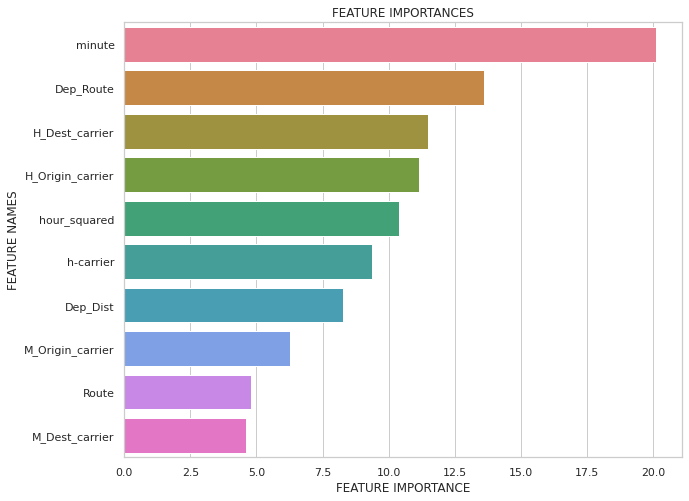

In [75]:
plot_feature_importance(cat_classifier, x_train)